In [119]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.signal import find_peaks
from scipy import signal as ss
plt.rcParams.update({'font.size': 8})
from scipy import stats
import matplotlib

In [22]:
def load_data(filename):
    
    f = h5py.File(filename, 'r')
    data = f['Packed Data']
   
    return data

def spike_detection(signal):
    dt = 5e-5
    time = np.arange(len(signal))*dt
    spike_threshold = -10*10**(-3) 
    # need to check that this is okay on all the experiments...

    spike_mask, spike_dict = find_peaks(signal,height=spike_threshold, prominence=1*10**(-3))
    spike_times = time[spike_mask]
    
    return spike_times, time

def remove_bursts(spike_times, keep_first_spike=True):
    burst_removed = []
    last_spike_time = None
    burst_spike_time = None
    
    for spike_time in spike_times:
        if last_spike_time is None:
            last_spike_time = spike_time
            burst_removed.append(spike_time)
        else:
            inter_event_interval = spike_time - last_spike_time
            if inter_event_interval >= 25e-3:
                burst_removed.append(spike_time)
                last_spike_time = spike_time
            elif burst_spike_time is None: 
                burst_spike_time = last_spike_time
                
    
    return burst_removed


def ISI(spike_times):
    isi = np.diff(spike_times)
    return isi

def response_statistics(isi_distribution):
    
    mu = np.mean(isi_distribution)
    sigma = np.std(isi_distribution)
    
    cv = sigma/mu
    firing_rate = 1/mu
    
    return firing_rate, cv

def bootstrap_response_statistics_error(isi_distribution):
    
    nb_samples = 10000
    isi_length = len(isi_distribution)
    
    FR_bootstrap = np.zeros(nb_samples)
    CV_bootstrap = np.zeros(nb_samples)
    
    for i in range(nb_samples):
        data_sample = np.random.choice(isi_distribution, size=isi_length)
        firing_rate, cv= response_statistics(data_sample)
        
        FR_bootstrap[i] = firing_rate
        CV_bootstrap[i] = cv
        
    firing_rate_error = np.std(FR_bootstrap)
    cv_error = np.std(CV_bootstrap)
    
    return firing_rate_error, cv_error

In [4]:
f = h5py.File('CA1dataAnes/121027_2.h5xp', 'r')

In [5]:
f

<HDF5 file "121027_2.h5xp" (mode r)>

In [6]:
list(f.keys())

['History',
 'Miscellaneous',
 'Packed Data',
 'Packed Procedure Files',
 'Recreation']

In [7]:
data = f['Packed Data']

In [8]:
keys_view = data.keys()
keys_array = np.array(list(keys_view))
print(keys_array)

['Pulse_4_1_1' 'Pulse_4_2_1' 'Pulse_4_3_1' 'Pulse_4_4_1' 'Pulse_4_5_1'
 'Pulse_6_1_1' 'Pulse_6_2_1' 'Pulse_6_3_1' 'Pulse_6_4_1' 'Pulse_6_5_1'
 'Pulse_7_1_1' 'Pulse_7_2_1' 'Pulse_7_3_1' 'Pulse_7_4_1' 'Pulse_7_5_1'
 'WaveSkip' 'stimString' 'pptLastPulseWave' 'CurrentPrefix' 'Xwave'
 'WinGlobals' 'Packages' 'Pulse_6' 'Pulse_8' 'Pulse_1' 'Pulse_2' 'Pulse_3'
 'Pulse_4' 'ChanA']


In [9]:
sweep_number = 7

# Select elements where the first number matches the reference number
selected_elements = [s for s in keys_array if re.match(r'^\w+_(\d+)_\d+_\d+$', s) and int(s.split('_')[1]) == sweep_number]
# Print the selected elements
print(selected_elements)

['Pulse_7_1_1', 'Pulse_7_2_1', 'Pulse_7_3_1', 'Pulse_7_4_1', 'Pulse_7_5_1']


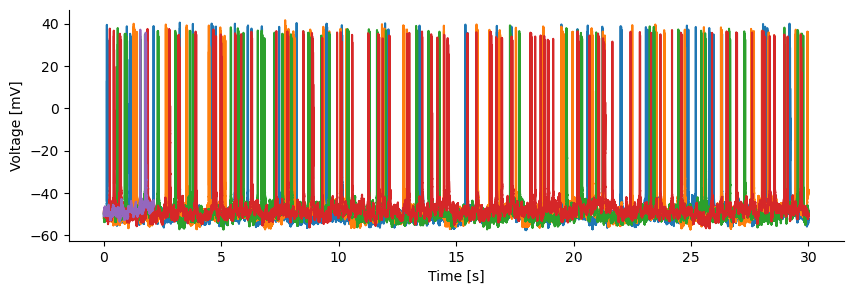

In [10]:
dt = 5e-5
plt.figure(figsize=(10,3))
for pulse_number in selected_elements:

    pulse = data[pulse_number]
    time = np.arange(len(pulse[:]))*dt

    plt.plot(time, pulse[:]*10**3)
    
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')

sns.despine()

[0.1272, 0.15295, 0.97675, 1.0092, 1.11765, 2.11645, 3.2329000000000003, 3.78905, 4.58965, 4.654100000000001, 4.77235, 5.57965, 6.1265, 6.2860000000000005, 6.72505, 7.46365, 8.2066, 9.4832, 10.132950000000001, 11.9741, 12.1163, 13.43945, 15.394, 15.491200000000001, 16.732300000000002, 17.3463, 19.4828, 20.165750000000003, 20.6033, 21.22195, 22.00395, 22.044050000000002, 23.079050000000002, 23.153200000000002, 23.39235, 23.517100000000003, 24.82565, 24.887, 25.2037, 25.776600000000002, 25.8245, 25.95925, 26.310450000000003, 28.0671, 28.156100000000002, 28.248250000000002, 29.19405, 29.221700000000002]


(11.9, 12.3)

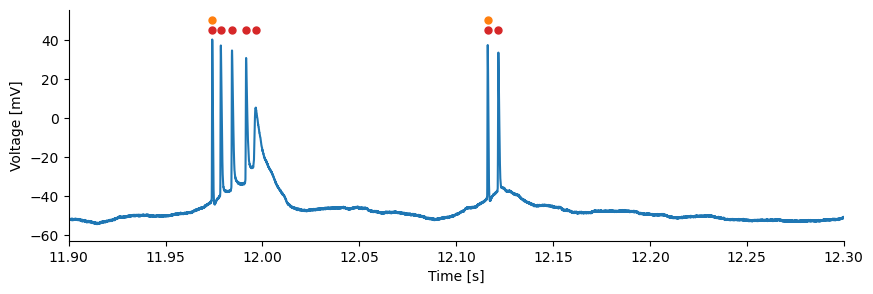

In [15]:
# code to extract the spiketimes
example_pulse = 'Pulse_7_1_1'
pulse = data[example_pulse]
signal = pulse[:]
spike_times, time = spike_detection(signal)

spike_times_no_burst = remove_bursts(spike_times, keep_first_spike=False)

print(spike_times_no_burst)
# Plot the results
plt.figure(figsize=(10,3))
plt.plot(time, signal*10**3)
plt.plot(spike_times, np.ones(len(spike_times))*45, '.', ms=10, color='tab:red')
plt.plot(spike_times_no_burst, np.ones(len(spike_times_no_burst))*50, '.', ms=10, color='tab:orange')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
sns.despine()
plt.xlim([11.9,12.3])


600000


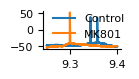

In [115]:
f = h5py.File('CA1dataAnes/121027_2.h5xp', 'r')
data = f['Packed Data']
example_pulse = 'Pulse_7_2_1'
pulse = data[example_pulse]
signal = pulse[:]
spike_times, time = spike_detection(signal)

f = h5py.File('CA1dataAnes/130114_2.h5xp', 'r')
example_pulse = 'Pulse_5_4_1'
data = f['Packed Data']
pulse = data[example_pulse]
signal2 = pulse[:]
spike_times, time = spike_detection(signal)

time_length = len(time)
dt = time[1]-time[0]
print(time_length)
max_time = int(9.4/dt)
min_time = int(9.25/dt)
# Plot the results
plt.figure(figsize=(1, 0.5))
plt.plot(time[min_time:max_time], signal[min_time:max_time]*10**3, label='Control')
plt.plot(time[min_time:max_time], signal2[min_time:max_time]*10**3, label='MK801')
#plt.plot(spike_times, np.ones(len(spike_times))*45, '.', ms=10, color='tab:red')
#plt.xlabel('Time [s]')
#plt.ylabel('Voltage [mV]')
sns.despine()
#plt.xlim([0,4])
#plt.xticks([0, 1, 2, 3, 4])

plt.legend(frameon=False)
#plt.tight_layout()
plt.savefig('../results/CA1_traces.svg')

Each neuron in the above plot had 100 pA injected

[0.1272, 0.15295, 0.97675, 1.0092, 1.11765, 2.11645, 3.2329000000000003, 3.78905, 4.58965, 4.654100000000001, 4.77235, 5.57965, 6.1265, 6.2860000000000005, 6.72505, 7.46365, 8.2066, 9.4832, 10.132950000000001, 11.9741, 12.1163, 13.43945, 15.394, 15.491200000000001, 16.732300000000002, 17.3463, 19.4828, 20.165750000000003, 20.6033, 21.22195, 22.00395, 22.044050000000002, 23.079050000000002, 23.153200000000002, 23.39235, 23.517100000000003, 24.82565, 24.887, 25.2037, 25.776600000000002, 25.8245, 25.95925, 26.310450000000003, 28.0671, 28.156100000000002, 28.248250000000002, 29.19405, 29.221700000000002]


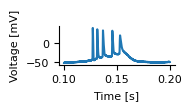

In [80]:
f = h5py.File('CA1dataAnes/121027_2.h5xp', 'r')
data = f['Packed Data']
example_pulse = 'Pulse_7_1_1'
pulse = data[example_pulse]
signal = pulse[:]
spike_times, time = spike_detection(signal)

spike_times_no_burst = remove_bursts(spike_times, keep_first_spike=False)

print(spike_times_no_burst)
# Plot the results
min_time = int(0.1/dt)
max_time = int(0.2/dt)
plt.figure(figsize=(1.5, 0.5))
plt.plot(time[min_time:max_time], signal[min_time:max_time]*10**3)

plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
sns.despine()

In [17]:
# make dictionary with exp numbers and info
# This was copied over from the data word doc in the zip file

exp_meta_data = {} # make each key an experiment. 

exp_meta_data['Control'] = {}
exp_meta_data['MK801'] = {}

exp_meta_data['Control']['121027_2'] = {'sweep':[4,6,7], 'current':[0, 50, 100]}
exp_meta_data['Control']['121207_2'] = {'sweep':[1,4,5], 'current':[0, 85, 132]}
exp_meta_data['Control']['130814_1'] = {'sweep':[3,4,5], 'current':[0, 50, 100]}
exp_meta_data['Control']['130815_1'] = {'sweep':[3,4], 'current':[0, 60]}
exp_meta_data['Control']['130815b_1'] = {'sweep':[8,9], 'current':[0, 100]}

exp_meta_data['MK801']['130114_2'] = {'sweep':[3,4,5], 'current':[0, 50, 100]}
exp_meta_data['MK801']['131130_2'] = {'sweep':[7,8,9], 'current':[0, 50, 115]}
exp_meta_data['MK801']['131130_4'] = {'sweep':[12,14,15], 'current':[0, 70, 120]}
exp_meta_data['MK801']['131201_3'] = {'sweep':[12,14,15,16], 'current':[0, 50, 100, 150]}

In [18]:
exp_names = exp_meta_data['Control'].keys()
print(exp_names)

dict_keys(['121027_2', '121207_2', '130814_1', '130815_1', '130815b_1'])


In [19]:
# Loop through sweeps in an experiment and pool inter spike intervals
exp_data = {}

# Loop over conditions, Control and MK801
for condition in exp_meta_data.keys():
    exp_data[condition] = {}
    
    # Loop through experiments
    for exp_name in exp_meta_data[condition].keys():
        
        filename = 'CA1dataAnes/' + exp_name + '.h5xp'
        data = load_data(filename)
        
        # Get keys of data dictionary
        keys_view = data.keys()
        keys_array = np.array(list(keys_view))

        sweep_numbers = exp_meta_data[condition][exp_name]['sweep']
        current_numbers = exp_meta_data[condition][exp_name]['current']

        # Create dict for saving pooled ISI distributions
        exp_data[condition][exp_name] = {}

        for i, sweep_number in enumerate(sweep_numbers): 

            current = current_numbers[i]

            exp_data[condition][exp_name][sweep_number] = {'ISIs':[], 'current':current}


            runs_in_sweep = [s for s in keys_array if re.match(r'^\w+_(\d+)_\d+_\d+$', s) and int(s.split('_')[1]) == sweep_number]
            #print(runs_in_sweep)

            # Loop through each run in the sweep and calculate the ISI
            for run in runs_in_sweep: 
                #print(run)

                signal = data[run][:]
                spike_times, time = spike_detection(signal)
                isi = ISI(spike_times)
                
                #print(f'EXP NAME: {exp_name}, SWEEP:{sweep_number}, RUN:{run}, NUM ISI: {len(isi)}')


                exp_data[condition][exp_name][sweep_number]['ISIs'].append(isi)

            exp_data[condition][exp_name][sweep_number]['ISIs'] = np.concatenate(exp_data[condition][exp_name][sweep_number]['ISIs'])

    

In [33]:
# combine isi's into single array

response_data = {}

# Loop over conditions, Control and MK801
for condition in exp_data.keys():
    response_data[condition] = {'firing_rate':[], 'cv':[], 'firing_rate_error':[], 'cv_error':[], 'current':[]}
    
    for exp_name in exp_data[condition]:
        for sweep in exp_data[condition][exp_name]:
            
            response_data[condition]['current'].append(exp_data[condition][exp_name][sweep]['current'])
            
            isi = exp_data[condition][exp_name][sweep]['ISIs']
            
            if len(isi)>=30:
                firing_rate, cv = response_statistics(isi)
                firing_rate_error, cv_error = bootstrap_response_statistics_error(isi)
                
                response_data[condition]['firing_rate'].append(firing_rate)
                response_data[condition]['cv'].append(cv)
                
                response_data[condition]['firing_rate_error'].append(firing_rate_error)
                response_data[condition]['cv_error'].append(cv_error)
                
            else: 
                response_data[condition]['firing_rate'].append(np.nan)
                response_data[condition]['cv'].append(np.nan)
                response_data[condition]['firing_rate_error'].append(np.nan)
                response_data[condition]['cv_error'].append(np.nan)

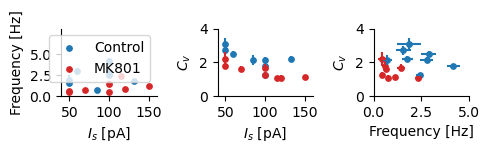

In [40]:

plt.figure(figsize=(1.5, 1.5))

plt.scatter(response_data['Control']['current'], response_data['Control']['firing_rate'], 
            label='Control', s=15, color='tab:blue')

plt.errorbar(response_data['Control']['current'], response_data['Control']['firing_rate'], 
             response_data['Control']['firing_rate_error'], fmt='None', color='tab:blue')


plt.scatter(response_data['MK801']['current'], response_data['MK801']['firing_rate'], label='MK801', s=15, color='tab:red')
plt.errorbar(response_data['MK801']['current'], response_data['MK801']['firing_rate'], 
             response_data['MK801']['firing_rate_error'], fmt='None', color='tab:red')

plt.ylabel('Frequency [Hz]')
plt.xlabel(r'$I_{s}$ [pA]')
sns.despine()
plt.ylim([0, 8])
plt.yticks([0, 2.5, 5])
plt.legend()
plt.tight_layout()
plt.xlim([40, 160])

plt.subplot(1,3,2)

plt.scatter(response_data['Control']['current'], response_data['Control']['cv'], label='Control', s=15, color='tab:blue')
plt.errorbar(response_data['Control']['current'], response_data['Control']['cv'], 
             response_data['Control']['cv_error'], fmt='None', color='tab:blue')

plt.scatter(response_data['MK801']['current'], response_data['MK801']['cv'], s=15, color='tab:red', label='MK801')
plt.errorbar(response_data['MK801']['current'], response_data['MK801']['cv'], 
             response_data['MK801']['cv_error'], fmt='None', color='tab:red')

plt.ylabel(r'$C_{v}$')
plt.xlabel(r'$I_{s}$ [pA]')
sns.despine()
plt.yticks([0, 2, 4])
plt.ylim([0, 4])
plt.xlim([40, 160])

plt.subplot(1,3,3)
plt.scatter(response_data['Control']['firing_rate'], response_data['Control']['cv'], label='Control', s=15, color='tab:blue')
plt.errorbar(response_data['Control']['firing_rate'], response_data['Control']['cv'], 
            yerr=response_data['Control']['cv_error'], xerr=response_data['Control']['firing_rate_error'], fmt='None', color='tab:blue')

plt.scatter(response_data['MK801']['firing_rate'], response_data['MK801']['cv'], label='MK801', s=15, color='tab:red')
plt.errorbar(response_data['MK801']['firing_rate'], response_data['MK801']['cv'], 
            yerr=response_data['MK801']['cv_error'], xerr=response_data['MK801']['firing_rate_error'], fmt='None', 
             color='tab:red')

sns.despine()

plt.ylabel(r'$C_{v}$')
plt.xlabel('Frequency [Hz]')

plt.xticks([0, 2.5, 5])
plt.yticks([0, 2, 4])
plt.ylim([0, 4])
plt.tight_layout()

plt.tight_layout()

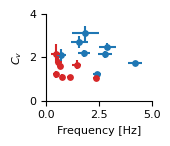

In [134]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(1.75, 1.5))
plt.scatter(response_data['Control']['firing_rate'], response_data['Control']['cv'], label='Control', s=15, color='tab:blue')
plt.errorbar(response_data['Control']['firing_rate'], response_data['Control']['cv'], 
            yerr=response_data['Control']['cv_error'], xerr=response_data['Control']['firing_rate_error'], fmt='None', color='tab:blue')

plt.scatter(response_data['MK801']['firing_rate'], response_data['MK801']['cv'], label='MK801', s=15, color='tab:red')
plt.errorbar(response_data['MK801']['firing_rate'], response_data['MK801']['cv'], 
            yerr=response_data['MK801']['cv_error'], xerr=response_data['MK801']['firing_rate_error'], fmt='None', 
             color='tab:red')

sns.despine()

plt.ylabel(r'$C_{v}$')
plt.xlabel('Frequency [Hz]')
plt.xticks([0, 2.5, 5])
plt.yticks([0, 2, 4])
plt.ylim([0, 4])
plt.tight_layout()
plt.savefig('../results/Grienberger_CV_f.svg')

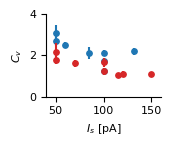

In [46]:
plt.figure(figsize=(1.75, 1.5))
plt.scatter(response_data['Control']['current'], response_data['Control']['cv'], label='Control', s=15, color='tab:blue')
plt.errorbar(response_data['Control']['current'], response_data['Control']['cv'], 
             response_data['Control']['cv_error'], fmt='None', color='tab:blue')

plt.scatter(response_data['MK801']['current'], response_data['MK801']['cv'], s=15, color='tab:red', label='MK801')
plt.errorbar(response_data['MK801']['current'], response_data['MK801']['cv'], 
             response_data['MK801']['cv_error'], fmt='None', color='tab:red')

plt.ylabel(r'$C_{v}$')
plt.xlabel(r'$I_{s}$ [pA]')
sns.despine()
plt.yticks([0, 2, 4])
plt.ylim([0, 4])
plt.xlim([40, 160])
plt.tight_layout()
plt.savefig('../results/Grienberger_CV_I.svg')

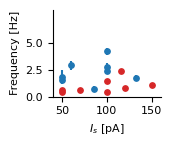

In [58]:
plt.figure(figsize=(1.75, 1.5))

plt.scatter(response_data['Control']['current'], response_data['Control']['firing_rate'], 
            label='Control', s=15, color='tab:blue')

plt.errorbar(response_data['Control']['current'], response_data['Control']['firing_rate'], 
             response_data['Control']['firing_rate_error'], fmt='None', color='tab:blue')


plt.scatter(response_data['MK801']['current'], response_data['MK801']['firing_rate'], label='MK801', s=15, color='tab:red')
plt.errorbar(response_data['MK801']['current'], response_data['MK801']['firing_rate'], 
             response_data['MK801']['firing_rate_error'], fmt='None', color='tab:red')

plt.ylabel('Frequency [Hz]')
plt.xlabel(r'$I_{s}$ [pA]')
sns.despine()
plt.ylim([0, 8])
plt.yticks([0, 2.5, 5])
#plt.legend()
plt.xlim([40, 160])
plt.tight_layout()
plt.savefig('../results/Grienberger_f_I.svg')

# Statistical test

In [117]:
CV_Control = np.asarray(response_data['Control']['cv']).flatten()
CV_MK801 = np.asarray(response_data['MK801']['cv']).flatten()

statistic, p_value = stats.ttest_ind(np.asarray(CV_Control).flatten(), np.asarray(CV_MK801).flatten(), equal_var=False, nan_policy='omit')
p_value

0.009900403511728984

C:\Users\Zach Friedenberger\AppData\Local\Temp\ipykernel_26812\2060391796.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


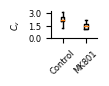

In [128]:
font = {'size'   : 6}
matplotlib.rc('font', **font)

plt.figure(figsize=(0.6, 0.35))

CV_MK801 = CV_MK801[~np.isnan(CV_MK801)]
CV_Control = CV_Control[~np.isnan(CV_Control)]

data = [CV_Control, CV_MK801]
boxplot_dict = plt.boxplot(data, flierprops={'markersize': 2})


sns.despine()
#plt.xlabel('$I_{d}$ [pA]')
plt.ylabel('$C_{v}$')

plt.ylim([0, 3.2])
plt.yticks([0, 1.5, 3])
plt.xticks([1,2], labels=['Control', 'MK801'], rotation=45)
#plt.xlim([-100, 800])
plt.tight_layout()

plt.savefig('../results/Grienberger_boxplot.svg')